### Overview of this notebook

* Introduction to time series classification, regression, clustering
* `sktime` data format fo "time series panels" = collections of time series
* Basic vignettes for TSC, TSR, TSCl
* Advanced vignettes - pipelines, ensembles, tuning

<!--TABLE OF CONTENTS-->
## Table of Contents
- [2. Learning tasks - Classification, Regression, Clustering & more <a name="top-2"></a>](#2.-Learning-tasks---Classification,-Regression,-Clustering-&-more-<a-name="top-2"></a>)
  - [2.1 Panel data - `sktime` data formats <a name="panel"></a>](#2.1-Panel-data---`sktime`-data-formats-<a-name="panel"></a>)
    - [2.1.1 preferred format 1 - `pd-multiindex` specification](#2.1.1-preferred-format-1---`pd-multiindex`-specification)
    - [2.1.2 preferred format 2 - `numpy3D` specification](#2.1.2-preferred-format-2---`numpy3D`-specification)
    - [2.1.3 loading and validity checking](#2.1.3-loading-and-validity-checking)
  - [2.2 Time Series Classification, Regression, Clustering - Basic Vignettes](#2.2-Time-Series-Classification,-Regression,-Clustering---Basic-Vignettes)
    - [2.2.3 Time Series Classification - deployment vignette](#2.2.3-Time-Series-Classification---deployment-vignette)
    - [2.2.4 Time Series Classification - simple evaluation vignette](#2.2.4-Time-Series-Classification---simple-evaluation-vignette)
    - [2.2.5 Time Series Regression - basic vignettes](#2.2.5-Time-Series-Regression---basic-vignettes)
    - [2.2.6 Time Series Clustering - basic vignettes](#2.2.6-Time-Series-Clustering---basic-vignettes)
  - [2.3 Searching for estimators, estimator tags](#2.3-Searching-for-estimators,-estimator-tags)
  - [2.4 Pipelines, Feature Extraction, Tuning, Composition](#2.4-Pipelines,-Feature-Extraction,-Tuning,-Composition)
    - [2.4.1 Primer on `sktime` transformers for feature extraction](#2.4.1-Primer-on-`sktime`-transformers-for-feature-extraction)
    - [2.4.2 Pipelines for time series panel tasks](#2.4.2-Pipelines-for-time-series-panel-tasks)
    - [2.4.3 Using transformers to deal with unequal length or missing values](#2.4.3-Using-transformers-to-deal-with-unequal-length-or-missing-values)
    - [2.4.4 Tuning and model selection](#2.4.4-Tuning-and-model-selection)
    - [2.4.5 Advanced Composition cheat sheet - AutoML, bagging, ensembles](#2.4.5-Advanced-Composition-cheat-sheet---AutoML,-bagging,-ensembles)
  - [2.5 Appendix - Extension guide](#2.5-Appendix---Extension-guide)
    - [Credits: notebook 11 - time series panel tasks - classification, regression, clustering](#Credits:-notebook-11---time-series-panel-tasks---classification,-regression,-clustering)

# 2. Learning tasks - Classification, Regression, Clustering & more <a name="top-2"></a>

deal with *collections of time series* = "panel data"

Classification = try to assign one *category* per time series, after training on time series/category examples

Example: osuleaf - circumference point distance of leaves. Predict type of tree

Regression = try to assign one *category* per time series, after training on time series/category examples

Example: temperature/pressure/time profile of chemical reactor. Predict total purity (fraction of 1)

Clustering = put different time series in a small number of similarity buckets

In [1]:
import pandas as pd

# Increase display width
pd.set_option('display.width', 1000)

## 2.1 Panel data - `sktime` data formats <a name="panel"></a>

Preferred format 1: `pd.DataFrame` with 2-level `MultiIndex`, (instance, time), cols= variables

Preferred format 2: 3D `np.ndarray` with index (instance, variable, time)

* `sktime` supports and recognizes multiple data formats for convenience and internal use, e.g., `dask`, `xarray`
* abstract data type = "scitype"; in-memory specification = "mtype"
* More information in tutorial on [in-memory data representations and data loading](https://www.sktime.net/en/latest/examples/AA_datatypes_and_datasets.html#In-memory-data-representations-and-data-loading)

### 2.1.1 preferred format 1 - `pd-multiindex` specification

`pd-multiindex` = `pd.DataFrame` with 2-level `MultiIndex`, (instance, time), cols= variables

The Arrow Heads dataset:

![](./img/arrowhead.png)

* The arrowhead data consists of outlines of the images of arrowheads. 
* The shapes of the projectile points are converted into a time series using the angle-based method.
* The classes are based on shape distinctions such as the presence and location of a notch in the arrow.
* The three classes are called "Avonlea", "Clovis" and "Mix".
* This dataset(along with many others) can be imported using sktime using a single line of code!

_How exactly are these outlines converted into images?_

* Length of all the points on the outlines are measured from its centroid.
* These lengths are then placed as distance from x-axis.

![](./img/two-dim-to-time-series.png)

Image Credits: Xiaopeng Xi et. al : [Finding Motifs in Database of Shapes](http://alumni.cs.ucr.edu/~xxi/SDM2007Motif.pdf)

In [2]:
from sktime.datasets import load_arrow_head

# load an example time series panel in pd-multiindex mtype
X, _ = load_arrow_head(return_type="pd-multiindex")

It contains:

* 211 (36 train, 175 test) individual time series instances
* one single variable per time series instances, `dim_0`, hence a univariate dataset
* individual time series are observed at 251 time points (the same number for all instances)

In [3]:
X

dim_0
    timepoints          
0   0          -1.963009
    1          -1.957825
    2          -1.956145
    3          -1.938289
    4          -1.896657
...                  ...
210 246        -1.513637
    247        -1.550431
    248        -1.581576
    249        -1.595273
    250        -1.620783

[52961 rows x 1 columns]

The Basic Motions Dataset:

* The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch.
* The watch collects 3D accelerometer and a 3D gyroscope. The data order is accelerometer x, y, z then gyroscope x, y, z.
* There are classes: walking, standing, running and badminton.
* Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [4]:
from sktime.datasets import load_basic_motions

# load an example time series panel in pd-multiindex mtype
X, y = load_basic_motions(return_type="pd-multiindex")

The basic motions dataset has:

* 80 individual time series instances
* six variables per time series instance, `dim_0` to `dim_5`, hence a multivariate dataset
* individual time series are observed at 100 time points (the same number for all instances)

In [5]:
# The outermost index represents the instance number
# whereas the inner index represents the index of the particular index
# within that instance.# (num_instances, num_variables, series_length)
X

dim_0      dim_1     dim_2     dim_3     dim_4     dim_5
   timepoints                                                              
0  0            0.079106   0.394032  0.551444  0.351565  0.023970  0.633883
   1            0.079106   0.394032  0.551444  0.351565  0.023970  0.633883
   2           -0.903497  -3.666397 -0.282844 -0.095881 -0.319605  0.972131
   3            1.116125  -0.656101  0.333118  1.624657 -0.569962  1.209171
   4            1.638200   1.405135  0.393875  1.187864 -0.271664  1.739182
...                  ...        ...       ...       ...       ...       ...
79 95          28.459024 -16.633770  3.631869  8.978229 -3.611533 -1.491489
   96          10.260094   0.102775  1.269261 -1.645964 -3.377157  1.283746
   97           4.316471  -3.574319  2.063831 -1.717875 -1.843054  0.484734
   98           0.704446  -4.920444  2.851857 -2.982977 -0.809665 -0.721774
   99          -2.074749  -6.892377  4.848379 -1.350330 -1.203844 -1.776470

[8000 rows x 6 columns]

pandas provides a simple way to access a range of value in the multi-indexed dataframe:

In [6]:
# Select the fourth variable of the first instance, all 100 timestamps
X.loc[0, 'dim_3']

timepoints
0     0.351565
1     0.351565
2    -0.095881
3     1.624657
4     1.187864
        ...   
95    0.039951
96   -0.029297
97    0.000000
98    0.000000
99   -0.007990
Name: dim_3, Length: 100, dtype: float64

Or if you want to access the individual values:

In [7]:
# Select only the fifth timepoint of the fourth variable of the first instance
X.loc[(0, 4), 'dim_3']

1.187864

Visualizing variations in the case of multivariate dataset, remains simple:

In [8]:
# Data for a participant who is standing
X_0, y_0 = X.loc[0].to_numpy(), y[0]
assert y_0 == "standing"

# Data for a participant who is running
X_10, y_10 = X.loc[10].to_numpy(), y[10]
assert y_10 == "running"

# Building the names of the variables
types = ["accelerometer", "gyroscope"]
titles = []
for type_ in types:
    for var in "XYZ":
        titles.append(type_ + "-" + var)

In [9]:
X_0.shape

(100, 6)

In [10]:
import matplotlib.pyplot as plt

def visualize_basic_motions(X_instance, y_instance):
    _, axs = plt.subplots(2, 3, figsize=(10, 7))
    axs = axs.ravel()

    for i, ax in enumerate(axs):
        data = X_instance[:, i]
        xs = [i for i in range(0, len(data))]
        ax.plot(xs, data)
        ax.set_title(titles[i])

    plt.suptitle("All Variables when the participant is " \
                + r"$\bf{" + f"{y_instance}" + "}$")
    plt.show()

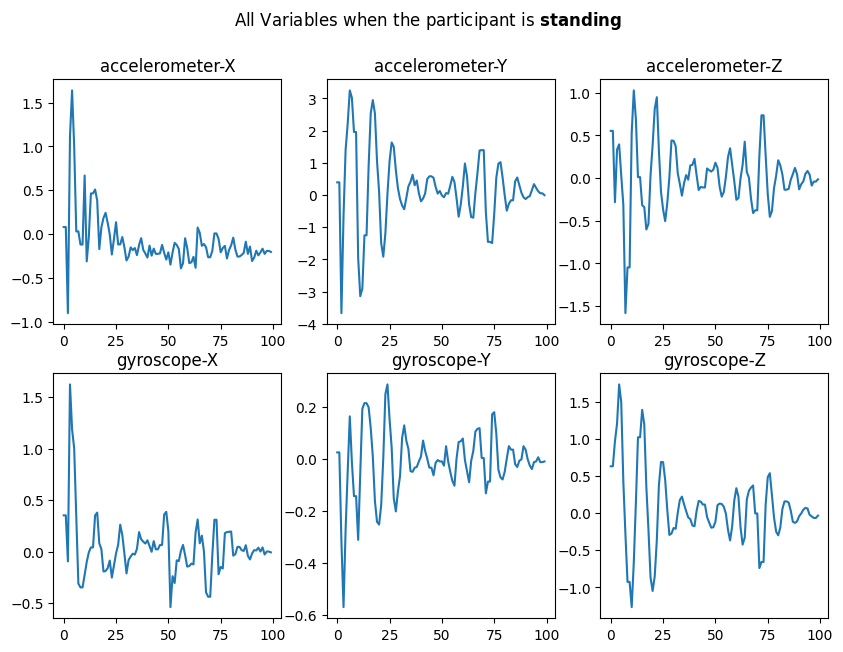

In [11]:
visualize_basic_motions(X_0, y_0)

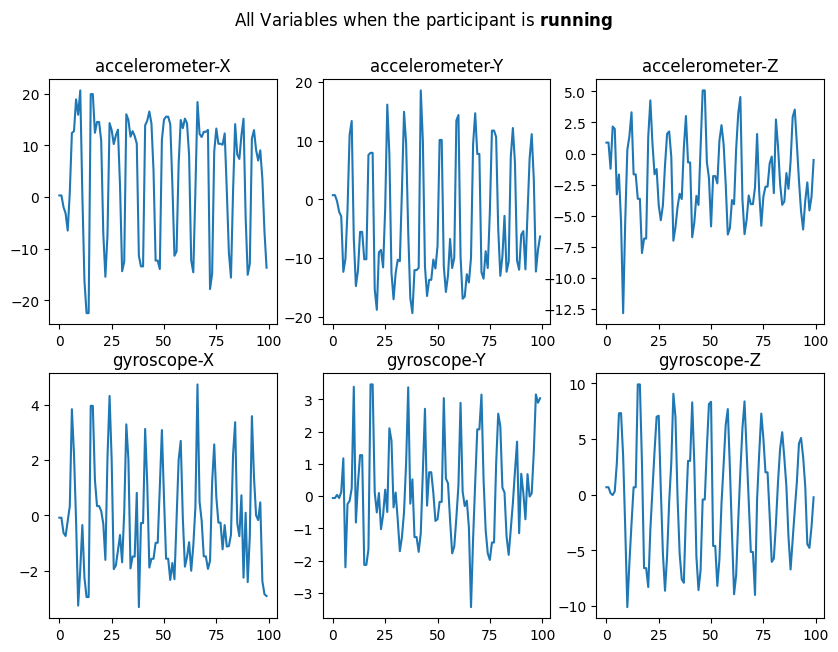

In [12]:
visualize_basic_motions(X_10, y_10)

### 2.1.2 preferred format 2 - `numpy3D` specification

`numpy3D` = 3D `np.ndarray` with index (instance, variable, time)

instance/time index is interpreted as integer

IMPORTANT: unlike `pd-multiindex`, this assumes:

* all individual series have the same length
* all individual series have the same index

In [13]:
from sktime.datasets import load_arrow_head

# load an example time series panel in numpy mtype
X, _ = load_arrow_head(return_type="numpy3D")

In [14]:
# (num_instances, num_variables, length)
X.shape

(211, 1, 251)

In [15]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")

The basic motions dataset has:

* 80 individual time series instances
* six variables per time series instance
* individual time series are observed at 100 time points (the same number for all instances)

In [16]:
X.shape

(80, 6, 100)

### 2.1.3 loading and validity checking

for custom data sets:

1. use `pandas.read_csv()` or similar utilities to obtain a `pd.DataFrame` or `np.ndarray`
2. try to bring the result in one of the preferred specifications
3. use the `check_is_mtype` utility to check compliance - inspect informative error messages
4. repeat 2-3 until the data format check passes

In [17]:
# let's pretend we just loaded this from csv
from sktime.datasets import load_arrow_head

X_pd, _ = load_arrow_head(return_type="pd-multiindex")

let's now check whether it complies with the `pd-multiindex` specification

In [18]:
from sktime.datatypes import check_is_mtype

valid, error_msg, metadata = check_is_mtype(X_pd, "pd-multiindex", return_metadata=True)

In [19]:
# is it valid?
valid

True

In [20]:
# helpful metadata, check if this is as per expectations
metadata

{'is_univariate': True,
 'is_empty': False,
 'has_nans': False,
 'n_instances': 211,
 'is_one_series': False,
 'is_equal_length': True,
 'is_equally_spaced': True,
 'n_panels': 1,
 'is_one_panel': True,
 'mtype': 'pd-multiindex',
 'scitype': 'Panel'}

let's see what happens if it is not in the expected format.

We have a `pd.DataFrame`, so if we check against `numpy3D`, it should complain:

In [21]:
valid, error_msg, metadata = check_is_mtype(X_pd, "numpy3D", return_metadata=True)

In [22]:
valid

False

In [23]:
error_msg

"obj must be a numpy.ndarray, found <class 'pandas.core.frame.DataFrame'>"

This tells us that we should first convert into `np.ndarray` as expected.

For further details on data formats, see the tutorial on [in-memory data representations and data loading](https://www.sktime.net/en/latest/examples/AA_datatypes_and_datasets.html#In-memory-data-representations-and-data-loading).

The "datatypes" tutorial also contains:

* full formal specifications of the mtypes (= machine representations)
* common examples for loading from csv and formatting
* utilities for loading and converting between different data formats for commonly used benchmark problems

All supported in-memory representations are python inspectable in `sktime.datatypes.MTYPE_REGISTER`

Note that this includes "exotic", rarely used ones and representations of objects that aren't time series.
Formats for time series panels are indicated by the `Panel` scitype.


## 2.2 Time Series Classification, Regression, Clustering - Basic Vignettes

Above tasks are very similar to "tabular" classification, regression, clustering, as in `sklearn`

Main distinction:
* in "tabular" classification etc, one (feature) instance row vector of features
* in TSC, one (feature) instance is a full time series, possibly unequal length, distinct index set

![](./img/tasks-tsc.png)


More formally:

* "tabular" classification: training pairs $(x_1, y_1), \dots, (x_n, y_n)$, where $x_i$ are rows of a `pd.DataFrame` (same col types), and $y_i \in \mathcal{C}$ for a finite set $y_i \in \mathcal{C}$. We use these to train a classifier that predicts $y_* \in \mathcal{C}$ for a `pd.DataFrame` row $x_*$
* time series classification: training pairs $(x_1, y_1), \dots, (x_n, y_n)$, where $x_i$ are time series from a certain domain, and $y_i \in \mathcal{C}$ for a finite set $y_i \in \mathcal{C}$. We use these to train a classifier that predicts $y_* \in \mathcal{C}$ for time series $x_*$

very similar for time series regression, clustering - exercise left to reader :-)

`sktime` design implications:

* need representation of collections of time series (panels), see Section 2.1
    * same as in "adjacent" learning tasks, e.g., panel forecasting
    * same as for transformation estimators
* algorithms that use sequentiality, can deal with unequal length, missing values etc 
* algorithms usually based on distances or kernels between time series - need to cover that in framework
* but we can use familiar `fit` / `predict` and `scikit-learn` / `scikit-base` interface!

### 2.2.3 Time Series Classification - deployment vignette

Basic deployment vignette for TSC:

1. load/setup training data, `X` in a `Panel` (more specifically `numpy3D`) format, `y` as 1D `np.ndarray`
2. load/setup new data for prediction (can be done after 2 too)
3. specify the classifier using `sklearn`-like syntax
4. fit classifier to training data, `fit(X, y)`
5. predict labels on new data, `predict(X_new)`

In [24]:
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_arrow_head

X_train, y_train = load_arrow_head(split="train", return_type="numpy3D")
X_new, _ = load_arrow_head(split="test", return_type="numpy3D")
X_new = X_new[:2]  # smaller dataset for faster notebook runtime

In [25]:
# this is in numpy3D format, but could also be pd-multiindex or other
X_train.shape

(36, 1, 251)

In [26]:
# y is a 1D np.ndarray of labels - same length as number of instances in X_train
y_train.shape

(36,)

In [27]:
# step 3 - specify the classifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

# example 1 - 3-NN with simple dynamic time warping distance (requires numba)
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3)

# example 2:
# 3-nearest neighbour classifier with mean (over time points) pairwise Euclidean distance
# (requires scipy)
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_tab_to_panel import AggrDist
from sktime.dists_kernels import ScipyDist

mean_eucl_dist = AggrDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=mean_eucl_dist)

we could specify any `sktime` classifier here - the rest remains the same!

In [28]:
# all classifiers is scikit-learn / scikit-base compatible!
# nested parameter interface via get_params, set_params
clf.get_params()

{'algorithm': 'brute',
 'distance': AggrDist(transformer=ScipyDist()),
 'distance_mtype': None,
 'distance_params': None,
 'leaf_size': 30,
 'n_jobs': None,
 'n_neighbors': 3,
 'pass_train_distances': False,
 'weights': 'uniform',
 'distance__aggfunc': None,
 'distance__aggfunc_is_symm': False,
 'distance__transformer': ScipyDist(),
 'distance__transformer__colalign': 'intersect',
 'distance__transformer__metric': 'euclidean',
 'distance__transformer__metric_kwargs': None,
 'distance__transformer__p': 2,
 'distance__transformer__var_weights': None}

In [29]:
# step 4 - fit/train the classifier
clf.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(distance=AggrDist(transformer=ScipyDist()),
                               n_neighbors=3)

In [30]:
# the classifier is now fitted
clf.is_fitted

True

In [31]:
# and we can inspect fitted parameters if we like
clf.get_fitted_params()

{'classes': array(['0', '1', '2'], dtype='<U1'),
 'fit_time': 2,
 'knn_estimator': KNeighborsClassifier(algorithm='brute', metric='precomputed', n_neighbors=3),
 'n_classes': 3,
 'knn_estimator__classes': array(['0', '1', '2'], dtype='<U1'),
 'knn_estimator__effective_metric': 'precomputed',
 'knn_estimator__effective_metric_params': {},
 'knn_estimator__n_features_in': 36,
 'knn_estimator__n_samples_fit': 36,
 'knn_estimator__outputs_2d': False}

In [32]:
# step 5 - predict labels on new data
y_pred = clf.predict(X_new)

In [33]:
# y_pred is an 1D np.ndarray, similar to sklearn classification output
y_pred

array(['2', '0'], dtype='<U1')

all together in one cell:

In [34]:
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_arrow_head

X_train, y_train = load_arrow_head(split="train", return_type="numpy3D")
X_new, _ = load_arrow_head(split="test", return_type="numpy3D")
X_new = X_new[:2]  # smaller dataset for faster notebook runtime

# step 3 - specify the classifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_tab_to_panel import AggrDist
from sktime.dists_kernels import ScipyDist

mean_eucl_dist = AggrDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=mean_eucl_dist)

# step 4 - fit/train the classifier
clf.fit(X_train, y_train)

# step 5 - predict labels on new data
y_pred = clf.predict(X_new)

### 2.2.4 Time Series Classification - simple evaluation vignette

Evaluation is simila to `sklearn` classifiers - we split a dataset and evaluate performance on the test set.

This includes as additional steps:

* splitting the initial, historical data, e.g., using `train_test_split`
* comparing predictions with a held out data set

In [35]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.datasets import load_arrow_head

# data should be split into train/test
X_train, y_train = load_arrow_head(split="train", return_type="numpy3D")
X_test, y_test = load_arrow_head(split="test", return_type="numpy3D")
X_test = X_test[:2]
y_test = y_test[:2]

# step 3-5 are the same
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_tab_to_panel import AggrDist
from sktime.dists_kernels import ScipyDist

mean_eucl_dist = AggrDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=mean_eucl_dist)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# for simplest evaluation, compare ground truth to predictions
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5

### 2.2.5 Time Series Regression - basic vignettes

TSR vignettes are exactly the same as TSC, except that:

* `y` in `fit` input and `predict` output should be float 1D `np.ndarray`, not categorical
* other algorithms are commonly used and/or performant

In [36]:
# steps 1, 2 - prepare dataset (train and new)
from sktime.datasets import load_covid_3month

X_train, y_train = load_covid_3month(split="train")
y_train = y_train.astype("float")
X_new, _ = load_covid_3month(split="test")
X_new = X_new.loc[:2]  # smaller dataset for faster notebook runtime

# step 3 - specify the regressor
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor

clf = KNeighborsTimeSeriesRegressor(n_neighbors=3, distance=mean_eucl_dist)

# step 4 - fit/train the regressor
clf.fit(X_train, y_train)

# step 5 - predict labels on new data
y_pred = clf.predict(X_new)

In [37]:
y_pred  # not too interesting but float

array([0., 0., 0.])

### 2.2.6 Time Series Clustering - basic vignettes

TS clustering is similar - 1st step is also `fit`, but unsupervised

i.e., no labels `y`, and next step is inspecting clusters

In [38]:
from sktime.clustering.dbscan import TimeSeriesDBSCAN

# step 1 - prepare dataset (train and new)
X, _ = load_arrow_head(split="train", return_type="numpy3D")
X = X[:10]

# step 2 - specify the clusterer
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_tab_to_panel import AggrDist
from sktime.dists_kernels import ScipyDist

mean_eucl_dist = AggrDist(ScipyDist())
clst = TimeSeriesDBSCAN(distance=mean_eucl_dist)

# step 3 - fit the clusterer to the data
clst.fit(X)

# step 4 - inspect the clustering
clst.get_fitted_params()

{'core_sample_indices': array([], dtype=int64),
 'dbscan': DBSCAN(metric='precomputed'),
 'fit_time': 166,
 'labels': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 'dbscan__components': array([], shape=(0, 10), dtype=float64),
 'dbscan__core_sample_indices': array([], dtype=int64),
 'dbscan__labels': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 'dbscan__n_features_in': 10}

## 2.3 Searching for estimators, estimator tags

Estimators in `sktime` are tagged.

Tags starting with "capability" indicate things the estimator can or cannot do, e.g.,

* `"capability:missing_values"` - dealing with missing values
* `"capability:multivariate"` - daling with multivariate input
* `"capability:unequal_length"` - deaing with time series panels where the individual time series have unequal length and/or unequal index

all tags for an estimator scitype (e.g., classifier, regressor) can be inspected by `sktime.registry.all_tags`:

In [39]:
from sktime.registry import all_tags

all_tags("classifier", as_dataframe=True)

,name,scitype,type,description
0,capability:contractable,classifier,bool,"contract time setting, does the estimator supp..."
1,capability:missing_values,"[classifier, early_classifier, param_est, regr...",bool,"can the classifier handle missing data (NA, np..."
2,capability:multithreading,"[classifier, early_classifier]",bool,can the classifier set n_jobs to use multiple ...
3,capability:multivariate,"[classifier, early_classifier, param_est, regr...",bool,can the classifier classify time series with 2...
4,capability:predict_proba,classifier,bool,does the classifier implement a non-default pr...
5,capability:train_estimate,classifier,bool,can the classifier estimate its performance on...
6,capability:unequal_length,"[classifier, early_classifier, regressor, tran...",bool,can the estimator handle unequal length time s...
7,classifier_type,classifier,"(list, [dictionary, distance, feature, hybrid,...",which type the classifier falls under in the t...


valid estimator types are listed in the `all_tags` docstring, or `sktime.registry.BASE_CLASS_REGISTER`

In [40]:
from sktime.registry import BASE_CLASS_REGISTER

# get only fist table column, the list of types
list(zip(*BASE_CLASS_REGISTER))[0]

('object',
 'estimator',
 'aligner',
 'classifier',
 'clusterer',
 'early_classifier',
 'forecaster',
 'metric',
 'network',
 'param_est',
 'regressor',
 'series-annotator',
 'splitter',
 'transformer',
 'transformer-pairwise',
 'transformer-pairwise-panel',
 'distribution')

to find all estimators of a certain type, use `sktime.registry.all_estimators`

In [41]:
# list all classifiers in sktime
from sktime.registry import all_estimators

all_estimators("classifier", as_dataframe=True)

2023-07-14 00:29:00.909775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 00:29:02.423598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,name,object
0,Arsenal,<class 'sktime.classification.kernel_based._ar...
1,BOSSEnsemble,<class 'sktime.classification.dictionary_based...
2,CNNClassifier,<class 'sktime.classification.deep_learning.cn...
3,CanonicalIntervalForest,<class 'sktime.classification.interval_based._...
4,Catch22Classifier,<class 'sktime.classification.feature_based._c...
5,ClassifierPipeline,<class 'sktime.classification.compose._pipelin...
6,ColumnEnsembleClassifier,<class 'sktime.classification.compose._column_...
7,ComposableTimeSeriesForestClassifier,<class 'sktime.classification.compose._ensembl...
8,ContractableBOSS,<class 'sktime.classification.dictionary_based...
9,DrCIF,<class 'sktime.classification.interval_based._...


for listing all estimators of a certain type with a certain capability,
use the `filter_tags` argument of `all_estimators`:

In [42]:
# list all classifiers in sktime
# that can classify panels of time series containing missing data
from sktime.registry import all_estimators

all_estimators("classifier", as_dataframe=True, filter_tags={"capability:missing_values": True})

,name,object
0,DummyClassifier,<class 'sktime.classification.dummy._dummy.Dum...
1,KNeighborsTimeSeriesClassifier,<class 'sktime.classification.distance_based._...
2,SklearnClassifierPipeline,<class 'sktime.classification.compose._pipelin...
3,TimeSeriesSVC,<class 'sktime.classification.kernel_based._sv...
4,WeightedEnsembleClassifier,<class 'sktime.classification.compose._ensembl...


side note:

don't worry about how short the list is - when in doubt, it is always possible to pipeline with `Imputer`

as in the next section :-)

## 2.4 Pipelines, Feature Extraction, Tuning, Composition


similar to `sklearn` for "tabular" classification, regression, etc,

`sktime` has a rich set of tools for:

* feature extraction via transformers
* pipeline transformers with any estimator
* tuning individual estimators or pipelines via grid search and similar
* building ensembles out of individual estimators, or other composites

`sktime` is also fully interoperable with `sklearn` interface if `numpy` based data mtypes are used

(although this loses support for unequal length time series)

### 2.4.1 Primer on `sktime` transformers for feature extraction

all `sktime` transformers work natively with panel data:

In [43]:
from sktime.datasets import load_osuleaf
from sktime.transformations.series.detrend import Detrender

# load some panel data
X, _ = load_osuleaf(return_type="pd-multiindex")

# specify a linear detrender
detrender = Detrender()

# detrend X by removing linear trend from each instance
X_detrended = detrender.fit_transform(X)
X_detrended.head()

dim_0
  timepoints          
0 0           1.275524
  1           1.186165
  2           1.093307
  3           1.007703
  4           0.917668

for panel tasks such as TSC, TSR, clustering, there are two distinctions to be aware of:

* series-to-series transformers transform individual series to series, panels to panels. E.g., instance-wise detrender above
* series-to-primitive transformers transform individual series to a set of tabular features. E>g., summary feature extractor

either type of transform can be instance-wise:

* instance-wise transforms use only the i-th series to transform the i-th series. E.g., instance-wise detrender
* non-instance-wise transforms train on all series to transform the i-th series. E.g., PCA, overall mean detrender

In [44]:
# example of a series-to-primitive transformer
from sktime.transformations.series.summarize import SummaryTransformer

# specify summary transformer
summary_trafo = SummaryTransformer()

# extract summary features - one per instance in the panel
X_summaries = summary_trafo.fit_transform(X)
X_summaries

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,5.620609e-12,1.0,-2.448026,2.164713,-1.372028,-0.653303,0.019166,0.759680,1.307684
1,-1.667213e-10,1.0,-2.039291,2.343680,-1.320366,-0.732177,0.012950,0.667696,1.546717
2,1.287588e-09,1.0,-1.745517,2.461347,-1.132094,-0.841825,-0.139335,0.822082,1.317306
3,5.105389e-11,1.0,-2.444381,2.478120,-1.256323,-0.662851,-0.100135,0.692753,1.336678
4,6.920375e-10,1.0,-1.622146,3.179546,-1.027063,-0.706940,-0.201367,0.472113,1.472487
...,...,...,...,...,...,...,...,...,...
437,-6.483747e-10,1.0,-2.526089,2.527529,-1.321163,-0.509245,0.007864,0.392470,1.356985
438,5.377752e-10,1.0,-2.158140,1.781019,-1.398347,-0.725591,0.120500,0.816865,1.279366
439,-8.843326e-10,1.0,-1.800577,2.510015,-1.098513,-0.776098,-0.192350,0.671332,1.495224
440,3.763466e-10,1.0,-2.054170,2.256243,-1.293714,-0.789295,0.130258,0.521019,1.338492


just like classifiers, we can search for transformers of either type via the right tag:

* `"scitype:transform-input"` and `"scitype:transform-output"` define input and output, e.g., "series-to-series" (both are scitype strings)
* `"scitype:instancewise"` is boolean and tells us whether the transform is instance-wise

In [45]:
# example: looking for all series-to-primitive transformers that are instance-wise
from sktime.registry import all_estimators

all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={
        "scitype:transform-input": "Series",
        "scitype:transform-output": "Primitives",
        "scitype:instancewise": True,
    },
)

,name,object
0,Catch22,<class 'sktime.transformations.panel.catch22.C...
1,Catch22Wrapper,<class 'sktime.transformations.panel.catch22wr...
2,FittedParamExtractor,<class 'sktime.transformations.panel.summarize...
3,RandomIntervalFeatureExtractor,<class 'sktime.transformations.panel.summarize...
4,RandomIntervals,<class 'sktime.transformations.panel.random_in...
5,RandomShapeletTransform,<class 'sktime.transformations.panel.shapelet_...
6,SignatureTransformer,<class 'sktime.transformations.panel.signature...
7,SummaryTransformer,<class 'sktime.transformations.series.summariz...
8,TSFreshFeatureExtractor,<class 'sktime.transformations.panel.tsfresh.T...
9,Tabularizer,<class 'sktime.transformations.panel.reduce.Ta...


Further details on transformations and feature extraction can be found in the tutorial 3, transformers.

All composition steps therein (e.g., chaining, column subsetting) work together with all estimator types in `sktime`, including classifiers, regressors, clusterers.

### 2.4.2 Pipelines for time series panel tasks

all panel estimators pipeline with `sktime` transformers, via the `*` dunder or `make_pipeline`.

The pipeline does the following:

* in `fit`: runs the transformers' `fit_transform` in sequence, then `fit` of the panel estimator
* in `predict`, runs the fitted transformers' `transform` in sequence, then `predict` of the panel estimator

(same logic as for `sklearn` pipelines)

In [46]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.series.exponent import ExponentTransformer

pipe = ExponentTransformer() * KNeighborsTimeSeriesClassifier()

# this constructs a ClassifierPipeline, which is also a classifier
pipe

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

In [47]:
# alternative to construct:
from sktime.pipeline import make_pipeline

pipe = make_pipeline(ExponentTransformer(), KNeighborsTimeSeriesClassifier())

In [48]:
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="TRAIN")
X_test, _ = load_unit_test(split="TEST")

# this is a forecaster with the same interface as knn-classifier
# first applies exponent transform, then knn-classifier
pipe.fit(X_train, y_train)

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

`sktime` transformers pipeline with `sklearn` classifiers!

This allows to build "time series feature extraction then `sklearn` classify`" pipelines:

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.series.summarize import SummaryTransformer

# specify summary transformer
summary_rf = SummaryTransformer() * RandomForestClassifier()

summary_rf.fit(X_train, y_train)

SklearnClassifierPipeline(classifier=RandomForestClassifier(),
                          transformers=[SummaryTransformer()])

### 2.4.3 Using transformers to deal with unequal length or missing values

pro tip: useful transformers to pipeline are those that "improve" capabilities!

Search for these transformer tags:

* `"capability:unequal_length:removes"` - ensures all instances in the panel have equal length afterwards. Examples: padding, cutting, resampling.
* `"capability:missing_values:removes"` - removes all missing values from the data (e.g., series, panel) passed to it. Example: mean imputation

In [50]:
# all transformers that guarantee that the output is equal length and equal index
from sktime.registry import all_estimators

all_estimators("transformer", as_dataframe=True, filter_tags={"capability:unequal_length:removes": True })

,name,object
0,ClearSky,<class 'sktime.transformations.series.clear_sk...
1,IntervalSegmenter,<class 'sktime.transformations.panel.segment.I...
2,PaddingTransformer,<class 'sktime.transformations.panel.padder.Pa...
3,RandomIntervalSegmenter,<class 'sktime.transformations.panel.segment.R...
4,SlopeTransformer,<class 'sktime.transformations.panel.slope.Slo...
5,TimeBinAggregate,<class 'sktime.transformations.series.binning....
6,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...


In [51]:
# all transformers that guarantee the output has no missing values
from sktime.registry import all_estimators

all_estimators("transformer", as_dataframe=True, filter_tags={"capability:missing_values:removes": True })

,name,object
0,ClearSky,<class 'sktime.transformations.series.clear_sk...
1,Imputer,<class 'sktime.transformations.series.impute.I...


minor note:

some transformers guarantee "no missing values" under some conditions but not always, e.g., `TimeBinAggregate`

let's check the tags in one example

In [52]:
# list all classifiers in sktime
from sktime.classification.feature_based import MatrixProfileClassifier

no_missing_clf = MatrixProfileClassifier()

no_missing_clf.get_tags()

{'X_inner_mtype': 'numpy3D',
 'capability:multivariate': False,
 'capability:unequal_length': False,
 'capability:missing_values': False,
 'capability:train_estimate': False,
 'capability:contractable': False,
 'capability:multithreading': True,
 'capability:predict_proba': True,
 'python_version': None,
 'requires_cython': False,
 'classifier_type': 'distance'}

In [53]:
from sktime.transformations.series.impute import Imputer

clf_can_do_missing = Imputer() * MatrixProfileClassifier()

clf_can_do_missing.get_tags()

{'X_inner_mtype': 'pd-multiindex',
 'capability:multivariate': False,
 'capability:unequal_length': False,
 'capability:missing_values': True,
 'capability:train_estimate': False,
 'capability:contractable': False,
 'capability:multithreading': False,
 'capability:predict_proba': True,
 'python_version': None,
 'requires_cython': False}

### 2.4.4 Tuning and model selection

`sktime` classifiers are compatible with `sklearn` model selection and composition tools using `sktime` data formats.

This extends to grid tuning and cross-validation, as long as `numpy` based formats or length/instance indexed formats are used.

In [54]:
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="TRAIN")
X_test, _ = load_unit_test(split="TEST")


Cross-validation using the `sklearn` `cross_val_score` and `KFold` functionality:

In [55]:
from sklearn.model_selection import KFold, cross_val_score
from sktime.classification.feature_based import MatrixProfileClassifier

clf = MatrixProfileClassifier()

cross_val_score(clf, X_train, y=y_train, cv=KFold(n_splits=4))

array([1. , 0.8, 0.6, 0.8])

Parameter tuning using `sklearn` `GridSearchCV`, we tune the _k_ and distance measure for a K-NN classifier:

In [56]:
from sklearn.model_selection import GridSearchCV

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_grid = {"n_neighbors": [1, 5], "distance": ["euclidean", "dtw"]}
parameter_tuning_method = GridSearchCV(knn, param_grid, cv=KFold(n_splits=4))

parameter_tuning_method.fit(X_train, y_train)
y_pred = parameter_tuning_method.predict(X_test)

### 2.4.5 Advanced Composition cheat sheet - AutoML, bagging, ensembles

* common ensembling patterns: `BaggingClassifier`, `WeightedEnsembleClassifier`
* composability with `sklearn` classifier, regressor building blocks still applies
* AutoML can be achieved by combining tuning with `MultiplexClassifier` or `MultiplexTransformer`

pro tip: bagging with a fixed single column subset can be used to turn an univariate classifier into a multivariate classifier!

## 2.5 Appendix - Extension guide

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed estimator, a good workflow to follow is:

0. find the right extension template for the type of estimator you want to add - e.g., classifier, regressor, clusterer, etc. The extension templates are located in the [`extension_templates](https://github.com/sktime/sktime/blob/main/extension_templates) directory
1. read through the extension template - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the base class - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.[name_of_task]`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_predict` and/or other methods (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the basic vignettes above.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

---

### Credits: notebook 11 - time series panel tasks - classification, regression, clustering

notebook creation: fkiraly, achieveordie